In [ ]:
#@title Input protein sequences
import os

os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from google.colab import files
import os.path
import re

import hashlib
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence_a = 'MSLWQPLVLVLLVLGCCFAAPRQRQSTLVLFPGDLRTNLTDRQLAEEYLYRYGYTRVAEM RGESKSLGPALLLLQKQLSLPETGELDSATLKAMRTPRCGVPDLGRFQTFEGDLKWHHHN ITYWIQNYSEDLPRAVIDDAFARAFALWSAVTPLTFTRVYSRDADIVIQFGVAEHGDGYP FDGKDGLLAHAFPPGPGIQGDAHFDDDELWSLGKGVVVPTRFGNADGAACHFPFIFEGRS YSACTTDGRSDGLPWCSTTANYDTDDRFGFCPSERLYTQDGNADGKPCQFPFIFQGQSYS ACTTDGRSDGYRWCATTANYDRDKLFGFCPTRADSTVMGGNSAGELCVFPFTFLGKEYST CTSEGRGDGRLWCATTSNFDSDKKWGFCPDQGYSLFLVAAHEFGHALGLDHSSVPEALMY PMYRFTEGPPLHKDDVNGIRHLYGPRPEPEPRPPTTTTPQPTAPPTVCPTGPPTVHPSER PTAGPTGPPSAGPTGPPTAGPSTATTVPLSPVDDACNVNIFDAIAEIGNQLYLFKDGKYW RFSEGRGSRPQGPFLIADKWPALPRKLDSVFEERLSKKLFFFSGRQVWVYTGASVLGPRR LDKLGLGADVAQVTGALRSGRGKMLLFSGRRLWRFDVKAQMVDPRSASEVDRMFPGVPLD THDVFQYREKAYFCQDRFYWRVSSRSELNQVDQVGYVTYDILQCPED' #@param {type:"string"}
query_sequence_a = "".join(query_sequence_a.split())
query_sequence_a = re.sub(r'[^A-Z]','', query_sequence_a.upper())

query_sequence_b = 'MMVEVRFFGPIKEENFFIKANDLKELRAILQEKEGLKEWLGVCAIALNDHLIDNLNTPLKDGDVISLLPPVCGG' #@param {type:"string"}
query_sequence_b = "".join(query_sequence_b.split())
query_sequence_b = re.sub(r'[^A-Z]','', query_sequence_b.upper())

# But we need linker of at least length 32
query_sequence_a = re.sub(r'U+',"U"*32,query_sequence_a)
query_sequence_b = re.sub(r'U+',"U"*32,query_sequence_b)

query_sequence = query_sequence_a + 'MMVEVRFFGPIKEENFFIKANDLKELRAILQEKEGLKEWLGVCAIALNDHLIDNLNTPLKDGDVISLLPPVCGG'

if len(query_sequence) > 1400:
  print(f"WARNING: For a typical Google-Colab-GPU (16G) session, the max total length is 1400 residues. You are at {len(query_sequence)}!")

jobname = 'test' #@param {type:"string"}
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)

num_models = 1 #@param [1] {type:"raw"}
msa_mode = "single_sequence" #@param ["MMseqs2","single_sequence"]
use_msa = True if msa_mode == "MMseqs2" else False
pair_msa = False #@param {type:"boolean"}
disable_mmseqs2_filter = pair_msa

with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("pair_msa=%s\n" % pair_msa)
    text_file.write("disable_mmseqs2_filter=%s\n" % disable_mmseqs2_filter)
 

In [ ]:
# Write line to file

with open('/seqcomb.txt', 'w') as writefile:
    writefile.write('Prot'+' '+query_sequence_a)#+query_sequence_b)

In [ ]:
#@title Install dependencies
%%bash -s $use_msa
USE_MSA=$1
if [ ! -f AF2_READY ]; then

  # install dependencies
  pip -q install biopython
  pip -q install dm-haiku
  pip -q install ml-collections
  pip -q install py3Dmol

  wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi
  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
    mkdir params
    tar -xf alphafold_params_2021-07-14.tar -C params/
    rm alphafold_params_2021-07-14.tar
  fi
  touch AF2_READY
fi


In [ ]:
#@title Import libraries
# setup the model
if "IMPORTED" not in dir():

  import time
  import requests
  import tarfile
  import sys
  import numpy as np
  import pickle

  from string import ascii_uppercase
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch

  import colabfold as cf

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt
  IMPORTED = True

def set_bfactor(pdb_filename, bfac, idx_res, chains):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      O.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def predict_structure(prefix, feature_dict, Ls, random_seed=0, num_models=1):  
  """Predicts structure using AlphaFold for the given sequence."""
  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
    idx_res[L_prev+L_i:] += 200
    L_prev += L_i  
  chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))
  feature_dict['residue_index'] = idx_res

  # Run the models.
  plddts = []
  paes = []
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  model_names = ["model_4","model_1","model_2","model_3","model_5"][:num_models]
  for n,model_name in enumerate(model_names):
    model_config = config.model_config(model_name+"_ptm")
    model_config.data.eval.num_ensemble = 1
    model_params = data.get_model_haiku_params(model_name+"_ptm", data_dir=".")

    if model_name == "model_4":
      model_runner = model.RunModel(model_config, model_params)
      processed_feature_dict = model_runner.process_features(feature_dict,random_seed=0)
    else:
      # swap params
      for k in model_runner.params.keys():
        model_runner.params[k] = model_params[k]

    print(f"running model_{n+1}")
    prediction_result = model_runner.predict(processed_feature_dict)

    # cleanup to save memory
    if model_name == "model_5": del model_runner
    del model_params
    
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
    plddts.append(prediction_result['plddt'])
    paes.append(prediction_result['predicted_aligned_error'])

    # Delete unused outputs to save memory.
    del prediction_result

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  plddts_ranked = {}
  paes_ranked = {}
  print("model\tplldt\tpae_ab")
  L = Ls[0]
  for n,r in enumerate(lddt_rank):
    plddt = plddts[r].mean()
    pae_ab = (paes[r][L:,:L].mean() + paes[r][:L,L:].mean()) / 2
    print(f"model_{n+1}\t{plddt:.2f}\t{pae_ab:.2f}")
    
    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f:
      f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path, plddts[r], idx_res, chains)

    plddts_ranked[f"model_{n+1}"] = plddts[r]
    paes_ranked[f"model_{n+1}"] = paes[r]

  return plddts_ranked, paes_ranked

# CODE FROM MINKYUNG/ROSETTAFOLD
def read_a3m(a3m_lines):
  '''parse an a3m files as a dictionary {label->sequence}'''
  seq = []
  lab = []
  is_first = True
  for line in a3m_lines.splitlines():
    if line[0] == '>':
      label = line.rstrip().split()[0][1:]
      is_incl = True
      if is_first: # include first sequence (query)
        is_first = False
        lab.append(label)
        continue
      if "UniRef" in label:
        code = label.split()[0].split('_')[-1]
        if code.startswith("UPI"): # UniParc identifier -- exclude
          is_incl = False
          continue
      elif label.startswith("tr|"):
        code = label.split('|')[1]
      else:
        is_incl = False
        continue
      lab.append(code)
    else:
      if is_incl:
        seq.append(line.rstrip())
      else:
        continue
  return seq, lab

# https://www.uniprot.org/help/accession_numbers
def uni2idx(ids):
  '''convert uniprot ids into integers according to the structure
  of uniprot accession numbers'''
  ids2 = [i.split("-")[0] for i in ids]
  ids2 = [i+'AAA0' if len(i)==6 else i for i in ids2]
  arr = np.array([list(s) for s in ids2], dtype='|S1').view(np.uint8)
  for i in [1,5,9]:
    arr[:,i] -= ord('0')
  arr[arr>=ord('A')] -= ord('A')
  arr[arr>=ord('0')] -= ord('0')-26
  arr[:,0][arr[:,0]>ord('Q')-ord('A')] -= 3
  arr = arr.astype(np.int64)
  coef = np.array([23,10,26,36,36,10,26,36,36,1], dtype=np.int64)
  coef = np.tile(coef[None,:],[len(ids),1])
  c1 = [i for i,id_ in enumerate(ids) if id_[0] in 'OPQ' and len(id_)==6]
  c2 = [i for i,id_ in enumerate(ids) if id_[0] not in 'OPQ' and len(id_)==6]
  coef[c1] = np.array([3, 10,36,36,36,1,1,1,1,1])
  coef[c2] = np.array([23,10,26,36,36,1,1,1,1,1])
  for i in range(1,10):
    coef[:,-i-1] *= coef[:,-i]
  return np.sum(arr*coef,axis=-1)

def run_mmseqs2(query_sequence, prefix, use_env=True, filter=False):
    def submit(query_sequence, mode):
      res = requests.post('https://a3m.mmseqs.com/ticket/msa', data={'q':f">1\n{query_sequence}", 'mode': mode})
      return res.json()
    def status(ID):
      res = requests.get(f'https://a3m.mmseqs.com/ticket/{ID}')
      return res.json()
    def download(ID, path):
      res = requests.get(f'https://a3m.mmseqs.com/result/download/{ID}')
      with open(path,"wb") as out: out.write(res.content)
      
    if filter:
      mode = "env" if use_env else "all"
    else:
      mode = "env-nofilter" if use_env else "nofilter"
    
    path = f"{prefix}_{mode}"
    if not os.path.isdir(path): os.mkdir(path)

    # call mmseqs2 api
    tar_gz_file = f'{path}/out.tar.gz'
    if not os.path.isfile(tar_gz_file):
      out = submit(query_sequence, mode)
      while out["status"] in ["RUNNING","PENDING"]:
        time.sleep(1)
        out = status(out["id"])    
      download(out["id"], tar_gz_file)
    
    # parse a3m files
    a3m_lines = []
    a3m = f"{prefix}_{mode}.a3m"
    if not os.path.isfile(a3m):
      with tarfile.open(tar_gz_file) as tar_gz: tar_gz.extractall(path)
      a3m_files = [f"{path}/uniref.a3m"]
      if use_env: a3m_files.append(f"{path}/bfd.mgnify30.metaeuk30.smag30.a3m")
      a3m_out = open(a3m,"w")
      for a3m_file in a3m_files:
        for line in open(a3m_file,"r"):
          line = line.replace("\x00","")
          if len(line) > 0:
            a3m_lines.append(line)
            a3m_out.write(line)
    else:
      a3m_lines = open(a3m).readlines()
    return "".join(a3m_lines), len(a3m_lines)

In [ ]:
#@title Call MMseqs2 to get MSA for each gene 

Ls = [len(query_sequence_a),len(query_sequence_b)]
msas = []
deletion_matrices = []
if use_msa:
  os.makedirs('tmp', exist_ok=True)
  prefix = hashlib.sha1(query_sequence.encode()).hexdigest()
  prefix = os.path.join('tmp',prefix)
  print(f"running mmseqs2 (use_env={True} filter={True})")
  a3m_lines = cf.run_mmseqs2([query_sequence_a, query_sequence_b], prefix, use_env=True, filter=True)
  if pair_msa:
    a3m_lines.append([])

    print(f"running mmseqs2 for pair_msa (use_env={False} filter={False})")
    a3m_lines_pair = cf.run_mmseqs2([query_sequence_a, query_sequence_b], prefix, use_env=False, filter=False)

    # CODE FROM MINKYUNG/ROSETTAFOLD
    msa1, lab1 = read_a3m(a3m_lines_pair[0])
    msa2, lab2 = read_a3m(a3m_lines_pair[1])
    if len(lab1) > 1 and len(lab2) > 1:
      # convert uniprot ids into integers
      hash1 = uni2idx(lab1[1:])
      hash2 = uni2idx(lab2[1:])

      # find pairs of uniprot ids which are separated by at most 10
      idx1, idx2 = np.where(np.abs(hash1[:,None]-hash2[None,:]) < 10)
      if idx1.shape[0] > 0:
        a3m_lines[2] = ['>query\n%s%s\n'%(msa1[0],msa2[0])]
        for i,j in zip(idx1,idx2):
           a3m_lines[2].append(">%s_%s\n%s%s\n"%(lab1[i+1],lab2[j+1],msa1[i+1],msa2[j+1]))
        
        msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(a3m_lines[2]))
        msas.append(msa)
        deletion_matrices.append(deletion_matrix)
        print("pairs found:",len(msa))
  
  msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines[0])
  msas.append([seq+"-"*Ls[1] for seq in msa])
  deletion_matrices.append([mtx+[0]*Ls[1] for mtx in deletion_matrix])

  msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines[1])
  msas.append(["-"*Ls[0]+seq for seq in msa])
  deletion_matrices.append([[0]*Ls[0]+mtx for mtx in deletion_matrix])

else:
  msas.append([query_sequence])
  deletion_matrices.append([[0]*len(query_sequence)])

feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=msas, deletion_matrices=deletion_matrices),
}

TypeError: ignored

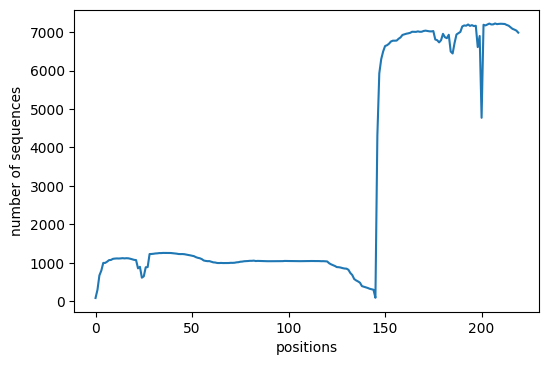

In [ ]:
#@title Plot Number of Sequences per Position
dpi =  100#@param {type:"integer"}
# confidence per position
plt.figure(dpi=dpi)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.savefig(jobname+"_msa_coverage.png")

plt.show()


In [ ]:
#@title Predict structure
plddts, paes = predict_structure(jobname, feature_dict, Ls=Ls, num_models=num_models)

running model_1
model	plldt	pae_ab
model_1	96.23	4.05


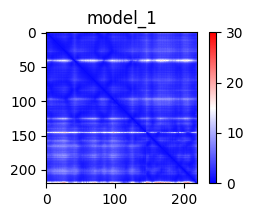

In [ ]:
#@title Plot Predicted Alignment Error
dpi =  100#@param {type:"integer"}

# confidence per position
plt.figure(figsize=(3*num_models,2), dpi=dpi)
for n,(model_name,value) in enumerate(paes.items()):
  plt.subplot(1,num_models,n+1)
  plt.title(model_name)
  plt.imshow(value,label=model_name,cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
plt.savefig(jobname+"_PAE.png")
plt.show()

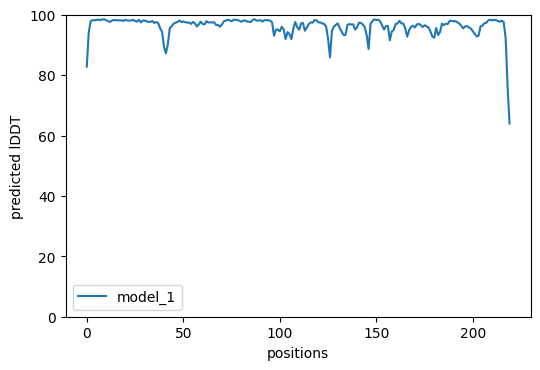

In [ ]:
#@title Plot lDDT per residue
# confidence per position
dpi =  100#@param {type:"integer"}
plt.figure(dpi=dpi)
for model_name,value in plddts.items():
  plt.plot(value,label=model_name)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted lDDT")
plt.xlabel("positions")
plt.savefig(jobname+"_lDDT.png")
plt.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

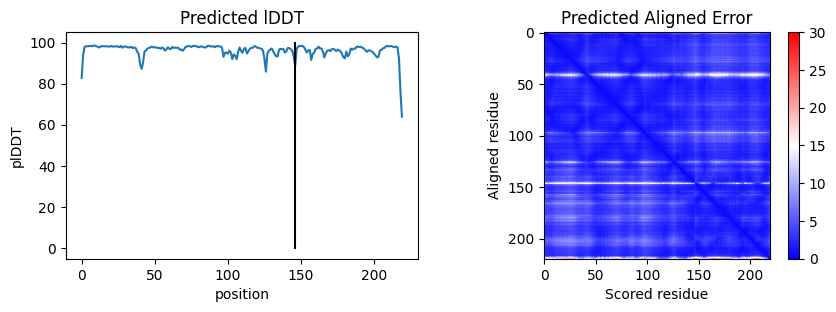

In [ ]:
#@title Display 3D structure {run: "auto"}
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "rainbow" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend():
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def plot_confidence(model_num=1):
  model_name = f"model_{model_num}"
  plt.figure(figsize=(10,3),dpi=100)
  """Plots the legend for plDDT."""
  #########################################
  plt.subplot(1,2,1); plt.title('Predicted lDDT')
  plt.plot(plddts[model_name])
  for x in [len(query_sequence_a)]:
    plt.plot([x,x],[0,100],color="black")

  plt.ylabel('plDDT')
  plt.xlabel('position')
  #########################################
  plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
  plt.imshow(paes[model_name], cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')
  #########################################
  return plt

def show_pdb(model_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"model_{model_num}"
  pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(2),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(model_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT": plot_plddt_legend().show()  
plot_confidence(model_num).show()

In [ ]:
import os
!pip install deeppurpose
!pip install rdkit-pypi
!pip install git+https://github.com/bp-kelley/descriptastorus
os.chdir('../')
from DeepPurpose import utils, DTI, dataset
from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 158 kB 5.4 MB/s 
     |████████████████████████████████| 348 kB 45.5 MB/s 
     |████████████████████████████████| 866 kB 36.3 MB/s 
     |████████████████████████████████| 133 kB 59.5 MB/s 
     |████████████████████████████████| 486 kB 56.5 MB/s 
     |████████████████████████████████| 503 kB 61.6 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
  Created wheel for deeppurpose: filename=DeepPurpose-0.1.5-py3-none-any.whl size=155674 sha256=829b5309f884a5f1ee841dfffed8080bd6ea6b3cd3d7a6038eadda12cb4b608a
  Stored in directory: /root/.cache/pip/wheels/18/1f/96/7af5b08dbce8b15baad8755dacfff167bd171df001022e0d68
  Created wheel for dgllife: filename=dgllife-0.2.8-py3-none-any.whl size=213162 sha256=d194bfeb83cd9a7a2fbaaae9003dfb4eacc9bc310ada213e6f528f0dad6ab542
  Stored in directory: /root/.cache/pip/wheels/b6/81/6f/6bbc4b7a80b06d92829b5362a78277173c9e7b46d294d4ca45
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3

In [ ]:
target, target_name = dataset.read_file_target_sequence('/seqcomb.txt')
print('The target is: ' + target)
print('The target name is: ' + target_name)

X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)
drug_encoding, target_encoding = 'MPNN', 'CNN'

config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         mpnn_hidden_size = 128,
                         mpnn_depth = 3, 
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

model = models.model_initialize(**config)

t, t_name = dataset.load_SARS_CoV2_Protease_3CL()


r, r_name, r_pubchem_cid = dataset.load_antiviral_drugs()

y_pred = models.repurpose(X_repurpose = r, target = target, model = model, drug_names =r_name, target_name = target_name, 
                       result_folder = "./result/", 
                       convert_y = True)

The target is: MSLWQPLVLVLLVLGCCFAAPRQRQSTLVLFPGDLRTNLTDRQLAEEYLYRYGYTRVAEMRGESKSLGPALLLLQKQLSLPETGELDSATLKAMRTPRCGVPDLGRFQTFEGDLKWHHHNITYWIQNYSEDLPRAVIDDAFARAFALWSAVTPLTFTRVYSRDADIVIQFGVAEHGDGYPFDGKDGLLAHAFPPGPGIQGDAHFDDDELWSLGKGVVVPTRFGNADGAACHFPFIFEGRSYSACTTDGRSDGLPWCSTTANYDTDDRFGFCPSERLYTQDGNADGKPCQFPFIFQGQSYSACTTDGRSDGYRWCATTANYDRDKLFGFCPTRADSTVMGGNSAGELCVFPFTFLGKEYSTCTSEGRGDGRLWCATTSNFDSDKKWGFCPDQGYSLFLVAAHEFGHALGLDHSSVPEALMYPMYRFTEGPPLHKDDVNGIRHLYGPRPEPEPRPPTTTTPQPTAPPTVCPTGPPTVHPSERPTAGPTGPPSAGPTGPPTAGPSTATTVPLSPVDDACNVNIFDAIAEIGNQLYLFKDGKYWRFSEGRGSRPQGPFLIADKWPALPRKLDSVFEERLSKKLFFFSGRQVWVYTGASVLGPRRLDKLGLGADVAQVTGALRSGRGKMLLFSGRRLWRFDVKAQMVDPRSASEVDRMFPGVPLDTHDVFQYREKAYFCQDRFYWRVSSRSELNQVDQVGYVTYDILQCPED
The target name is: Prot
Beginning Processing...
Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding p

In [ ]:
#@title Package and download results
!zip -FSr $jobname".result.zip" $jobname".log" $jobname"_msa_coverage.png" $jobname"_"*"relaxed_model_"*".pdb" $jobname"_lDDT.png"  $jobname"_PAE.png"
try:
  files.download(f"{jobname}.zip")
except:
  print ('Downloaded')


	zip warning: name not matched: test_d0f9f.log
	zip warning: name not matched: test_d0f9f_msa_coverage.png
	zip warning: name not matched: test_d0f9f_*relaxed_model_*.pdb
	zip warning: name not matched: test_d0f9f_lDDT.png
	zip warning: name not matched: test_d0f9f_PAE.png

zip error: Nothing to do! (try: zip -FSr test_d0f9f.result.zip . -i test_d0f9f.log test_d0f9f_msa_coverage.png test_d0f9f_*relaxed_model_*.pdb test_d0f9f_lDDT.png test_d0f9f_PAE.png)
Downloaded
